In [95]:
import torch
import torchvision
import torchvision.transforms as transforms

In [96]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [97]:
transform = transforms.ToTensor()

batch_size = 4
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 
            'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [98]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 9)

In [99]:
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

Ankle boot


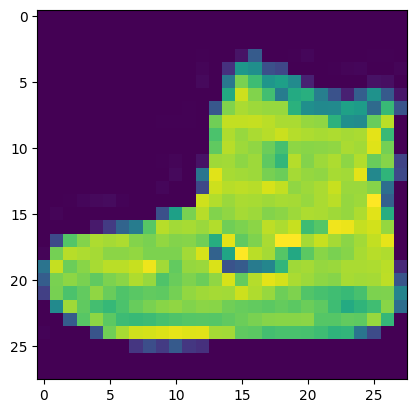

In [100]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
print(classes[label])
plt.imshow(np_img.reshape((28, 28, 1)))

In [101]:
len(trainset), len(testset)

(60000, 10000)

In [102]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [103]:
print(f'Number of batches in training set: {int(50000 / batch_size)}')

Number of batches in training set: 12500


In [104]:
print(f'Number of batches in validation set: {int(10000 / batch_size)}')

Number of batches in validation set: 2500


In [105]:
type(trainset)

torch.utils.data.dataset.Subset

In [106]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [107]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(p=0.3)

        self.out = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.out(x)

        return x

In [108]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [109]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([4, 1, 28, 28])
after network shape: torch.Size([4, 10])


In [110]:
num_parameters = 0
for x in net.parameters():
    num_parameters += len(torch.flatten(x))

print(f'Number of parameters: {num_parameters:,}')

Number of parameters: 8,536,074


In [111]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [112]:
def train_one_epoch():
    net.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 500 == 499:
            avg_loss_across_batches = running_loss / 500
            avg_acc_across_batches = (running_accuracy / 500) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))

            running_loss = 0.0
            running_accuracy = 0.0

    print()


In [113]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = net(inputs)
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_acc_across_batches))
    print('**********************************************************')
    print()
    

In [114]:
def run_model():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = net(inputs)
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    avg_loss_across_batches = running_loss / len(testloader)
    avg_acc_across_batches = (running_accuracy / len(testloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_acc_across_batches))
    print('**********************************************************')
    print()

In [115]:
num_epochs = 10

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')

    train_one_epoch()
    validate_one_epoch()

print('Finished Training')

Epoch: 1

Batch 500, Loss: 1.369, Accuracy: 48.2%
Batch 1000, Loss: 0.899, Accuracy: 65.5%
Batch 1500, Loss: 0.689, Accuracy: 74.5%
Batch 2000, Loss: 0.678, Accuracy: 75.5%
Batch 2500, Loss: 0.669, Accuracy: 74.5%
Batch 3000, Loss: 0.580, Accuracy: 77.4%
Batch 3500, Loss: 0.595, Accuracy: 77.1%
Batch 4000, Loss: 0.570, Accuracy: 79.4%
Batch 4500, Loss: 0.551, Accuracy: 79.5%
Batch 5000, Loss: 0.540, Accuracy: 80.3%
Batch 5500, Loss: 0.504, Accuracy: 81.0%
Batch 6000, Loss: 0.488, Accuracy: 81.5%
Batch 6500, Loss: 0.484, Accuracy: 82.8%
Batch 7000, Loss: 0.477, Accuracy: 82.4%
Batch 7500, Loss: 0.466, Accuracy: 82.3%
Batch 8000, Loss: 0.471, Accuracy: 83.2%
Batch 8500, Loss: 0.455, Accuracy: 83.2%
Batch 9000, Loss: 0.435, Accuracy: 83.3%
Batch 9500, Loss: 0.411, Accuracy: 84.9%
Batch 10000, Loss: 0.402, Accuracy: 84.7%
Batch 10500, Loss: 0.413, Accuracy: 85.6%
Batch 11000, Loss: 0.426, Accuracy: 84.2%
Batch 11500, Loss: 0.401, Accuracy: 85.7%
Batch 12000, Loss: 0.414, Accuracy: 84.7%
Ba

KeyboardInterrupt: 

In [ ]:
run_model()

Val Loss: 0.286, Val Accuracy: 91.0%
**********************************************************

